In [2]:
import pandas as pd
import pytrends
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
from pytrends.request import TrendReq

In [4]:
pytrends = TrendReq(hl='en-US', tz=360)

In [5]:
kw_list =["ESG"]
pytrends.build_payload(kw_list, geo ='GR')

In [6]:
df=pytrends.interest_over_time()

In [7]:
df.to_csv("greekGoogleTrendEsg.csv",sep=';')
df.head()
df['ESG'].dtype

dtype('int64')

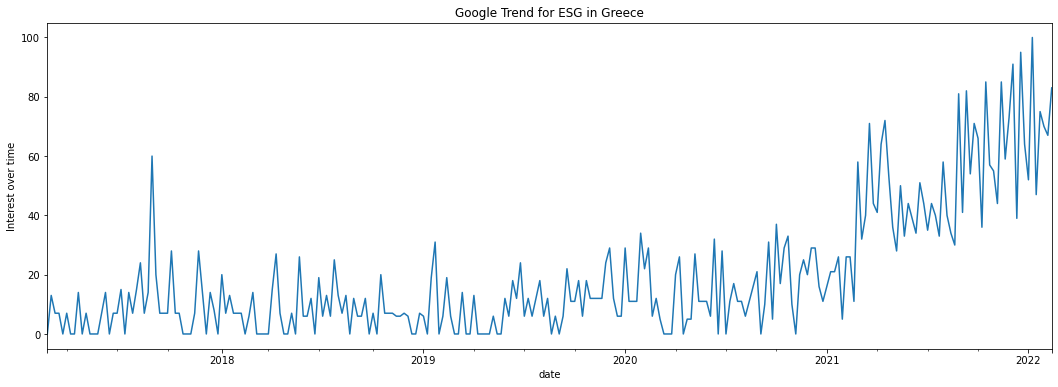

In [8]:
title='Google Trend for ESG in Greece'
ylabel='Interest over time'
ax=df['ESG'].plot(figsize=(18,6),title=title)
ax.set(ylabel=ylabel);

## ETS Decompositon model

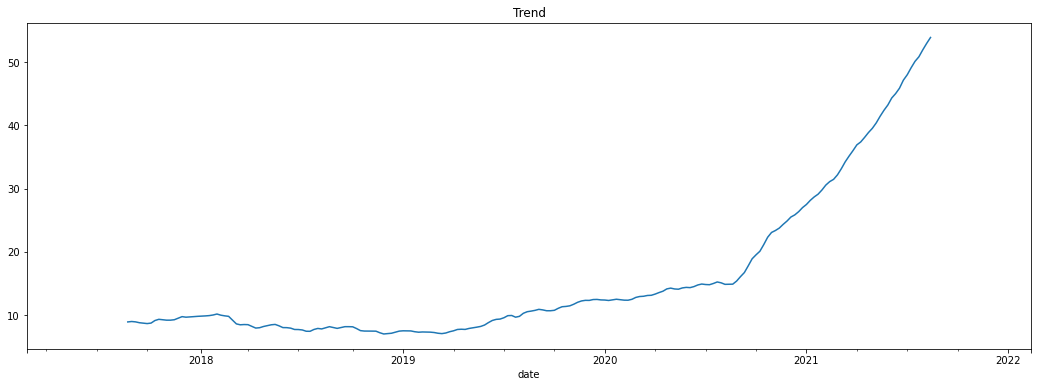

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize']=18,6

df.dropna(inplace=True)
result=seasonal_decompose(df['ESG'],model='additive')
result.trend.plot(title = "Trend");

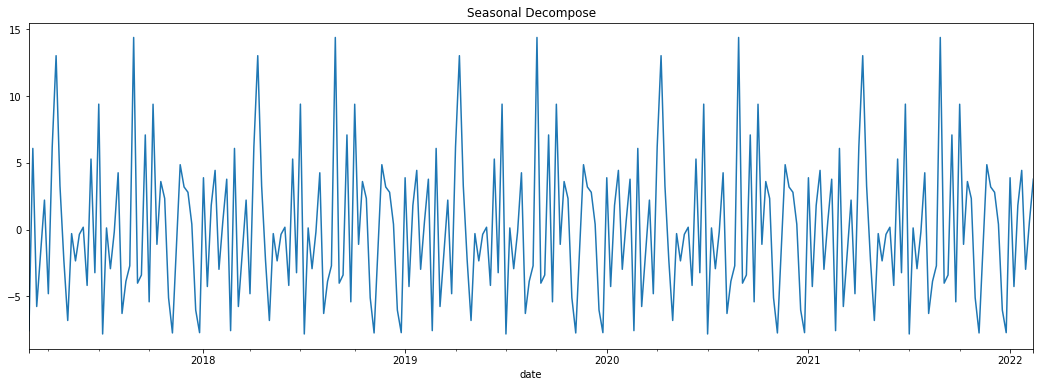

In [10]:
result.seasonal.plot(title="Seasonal Decompose", figsize=(18,6));

## 6-Month Simple Moving Average(SMA)

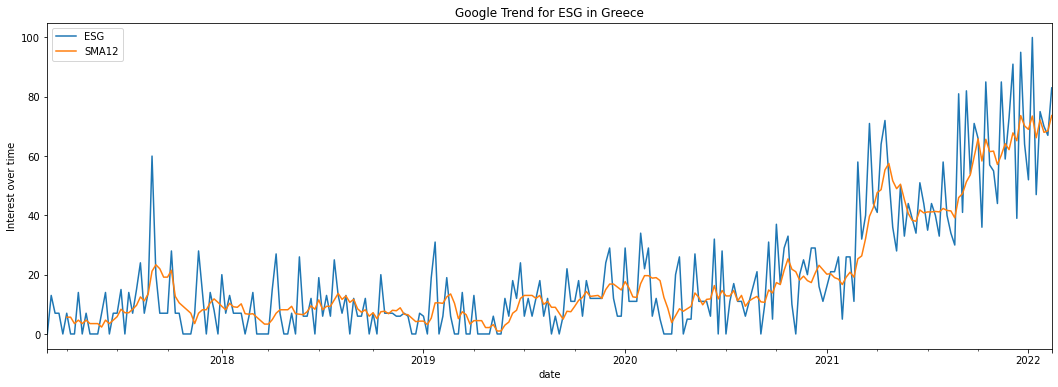

In [11]:
# 12months Simple Moving Average
df['SMA12']=df['ESG'].rolling(window=6).mean()
df[['ESG','SMA12']].plot(figsize=(18,6), title = title).set(ylabel = ylabel);

## Adding Exponentially Weighted Movining Average(EWMA) with 6 month span

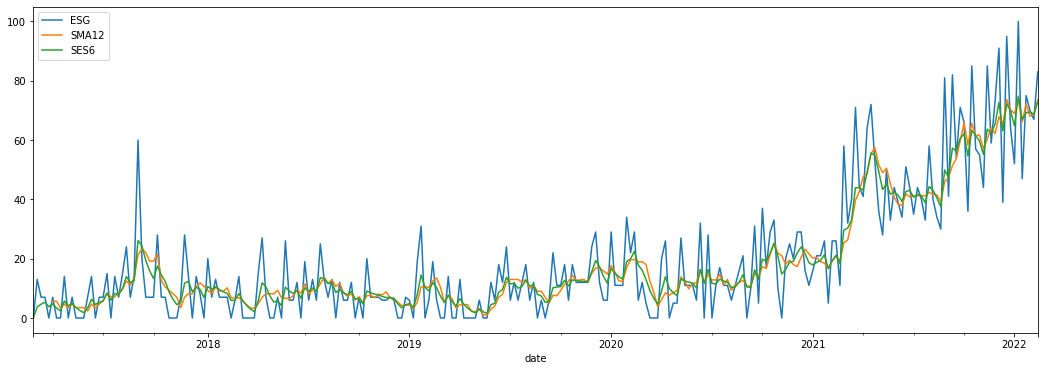

In [18]:
df['SES6']=df['ESG'].ewm(span=6,adjust=False).mean()
# df.head()
df[['ESG','SMA12','SES6']].plot();

## Adding Holt-Winters fitted model using Triple Exonential Smoothing with additive model

/home/giorgos/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/home/giorgos/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


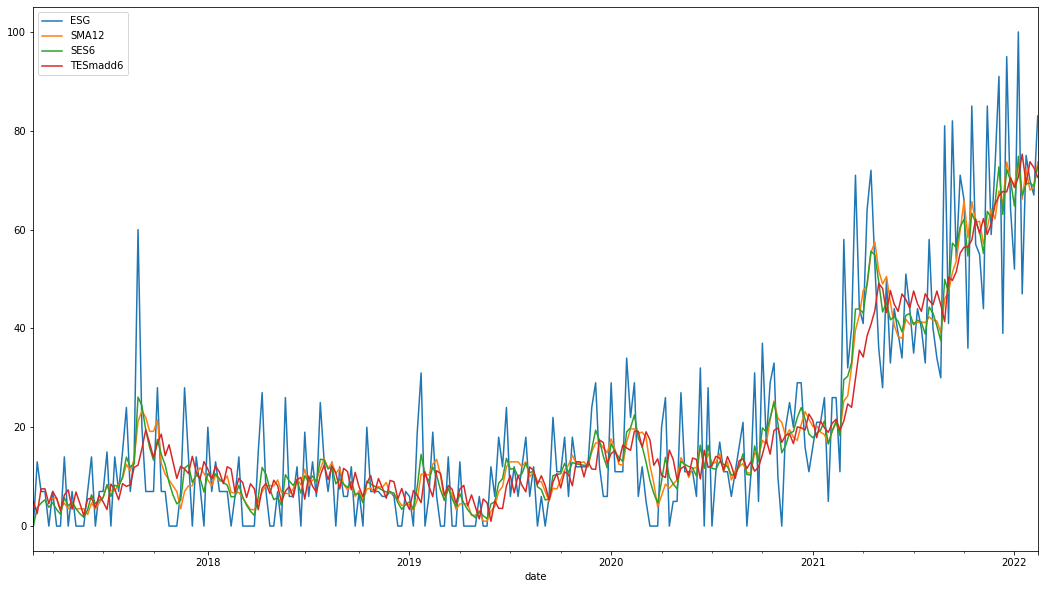

In [35]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
df['TESmadd6']=ExponentialSmoothing(df['ESG'],trend='add',seasonal='add',seasonal_periods=6).fit().fittedvalues
# df.head()
df.columns
df[['ESG', 'isPartial', 'SMA12', 'SES6', 'TESmadd6']].plot(figsize=(18,10));




### ESG google search in Greece the last 2 years

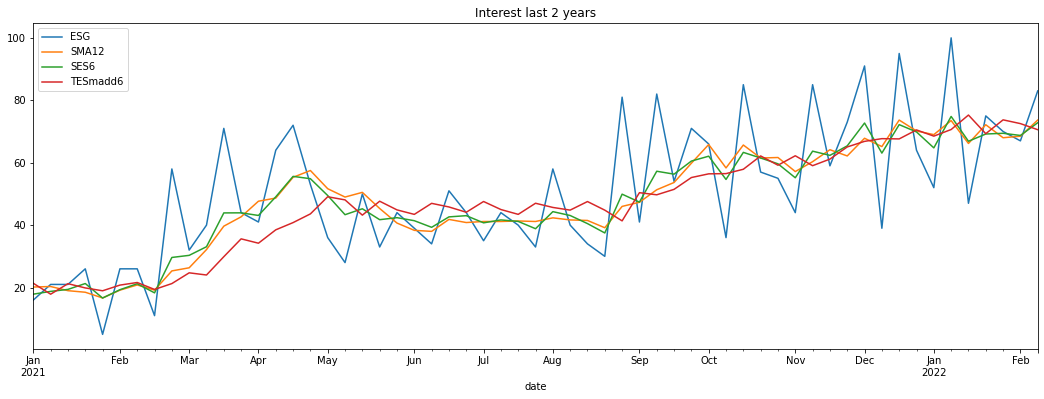

In [33]:
df[['ESG', 'isPartial', 'SMA12', 'SES6', 'TESmadd6']]['2021-01-01':].plot(title='Interest last 2 years');